# Recherche de facteurs d'influence sur le temps de sommeil
_Darnatigues Rémy / Guiraud Philippe_

## Nous allons ici procéder à l'analyse des variables quantitatives de notre modèle

Dans un premier temps, nous allons réimporter notre fichier et réappliquer les modifications réalisées.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tabulate import tabulate
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.set_option('display.precision', 2)
fichier = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv", sep=",")
fichier.drop('Person ID', axis = 1, inplace = True)
systolique = []  # valeur 1
diastolique = []  # valeur 2
for value in fichier["Blood Pressure"]:
    val_1, val_2 = value.split('/')
    systolique.append(int(val_1))  
    diastolique.append(int(val_2)) 
fichier['Systolic'] = systolique
fichier['Diastolic'] = diastolique
fichier.drop('Blood Pressure', axis = 1, inplace = True)
fichier["Sleep Disorder"] = fichier["Sleep Disorder"].fillna("Aucun")
fichier["BMI Category"] = fichier["BMI Category"].replace({"Normal Weight": "Normal"})
Y = fichier["Sleep Duration"]
genre = fichier["Gender"]
metier = fichier["Occupation"]
IMC = fichier["BMI Category"]
sleepdis = fichier["Sleep Disorder"]
age = fichier["Age"]
activ = fichier["Physical Activity Level"]
battement = fichier["Heart Rate"]
pas = fichier["Daily Steps"]
stress = fichier["Stress Level"]
systolique = fichier["Systolic"]
diastolique = fichier["Diastolic"]

  
#### Afin d'observer l'étendue et la distribution de nos variables, nous allons afficher le boxplot et l'histogramme de chacune d'entre elles.

In [6]:
print("Voici une présentation globale des variables quantitatives :")
fichier.describe()

Voici une présentation globale des variables quantitatives :


,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic
count,374.00,374.00,374.00,374.00,374.00,374.00,374.00,374.00,374.00
mean,42.18,7.13,7.31,59.17,5.39,70.17,6816.84,128.55,84.65
std,8.67,0.80,1.20,20.83,1.77,4.14,1617.92,7.75,6.16
min,27.00,5.80,4.00,30.00,3.00,65.00,3000.00,115.00,75.00
25%,35.25,6.40,6.00,45.00,4.00,68.00,5600.00,125.00,80.00
50%,43.00,7.20,7.00,60.00,5.00,70.00,7000.00,130.00,85.00
75%,50.00,7.80,8.00,75.00,7.00,72.00,8000.00,135.00,90.00
max,59.00,8.50,9.00,90.00,8.00,86.00,10000.00,142.00,95.00


##### Nous commençons par la variable cible, la durée du temps de sommeil :

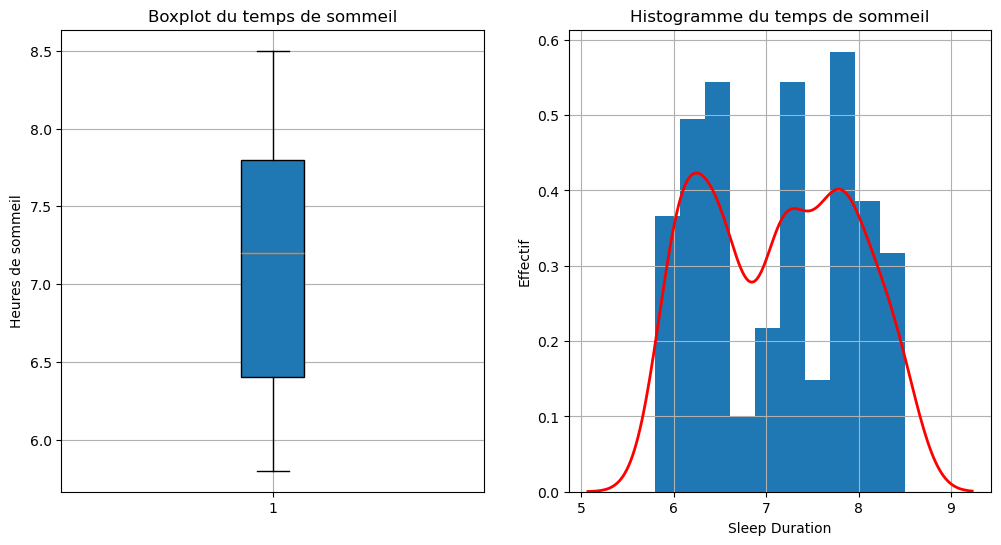

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 1er boxplot/histogramme
axes[0].boxplot(Y, patch_artist = True)
axes[0].set_title("Boxplot du temps de sommeil")
axes[0].set_ylabel("Heures de sommeil")
axes[0].grid(True)

axes[1].hist(Y, bins = 10, density = True)
sns.kdeplot(Y, color="red", ax=axes[1], linewidth=2)
axes[1].set_title("Histogramme du temps de sommeil")
axes[1].set_ylabel("Effectif")
axes[1].grid(True)

La variable "Temps de sommeil" semble symétrique à en juger par le boxplot. Par contre, la distribution ne suit pas une gaussienne ce qui risque de compliquer notre régression.

##### Faisons maintenant la même chose mais pour les variables explicatives :

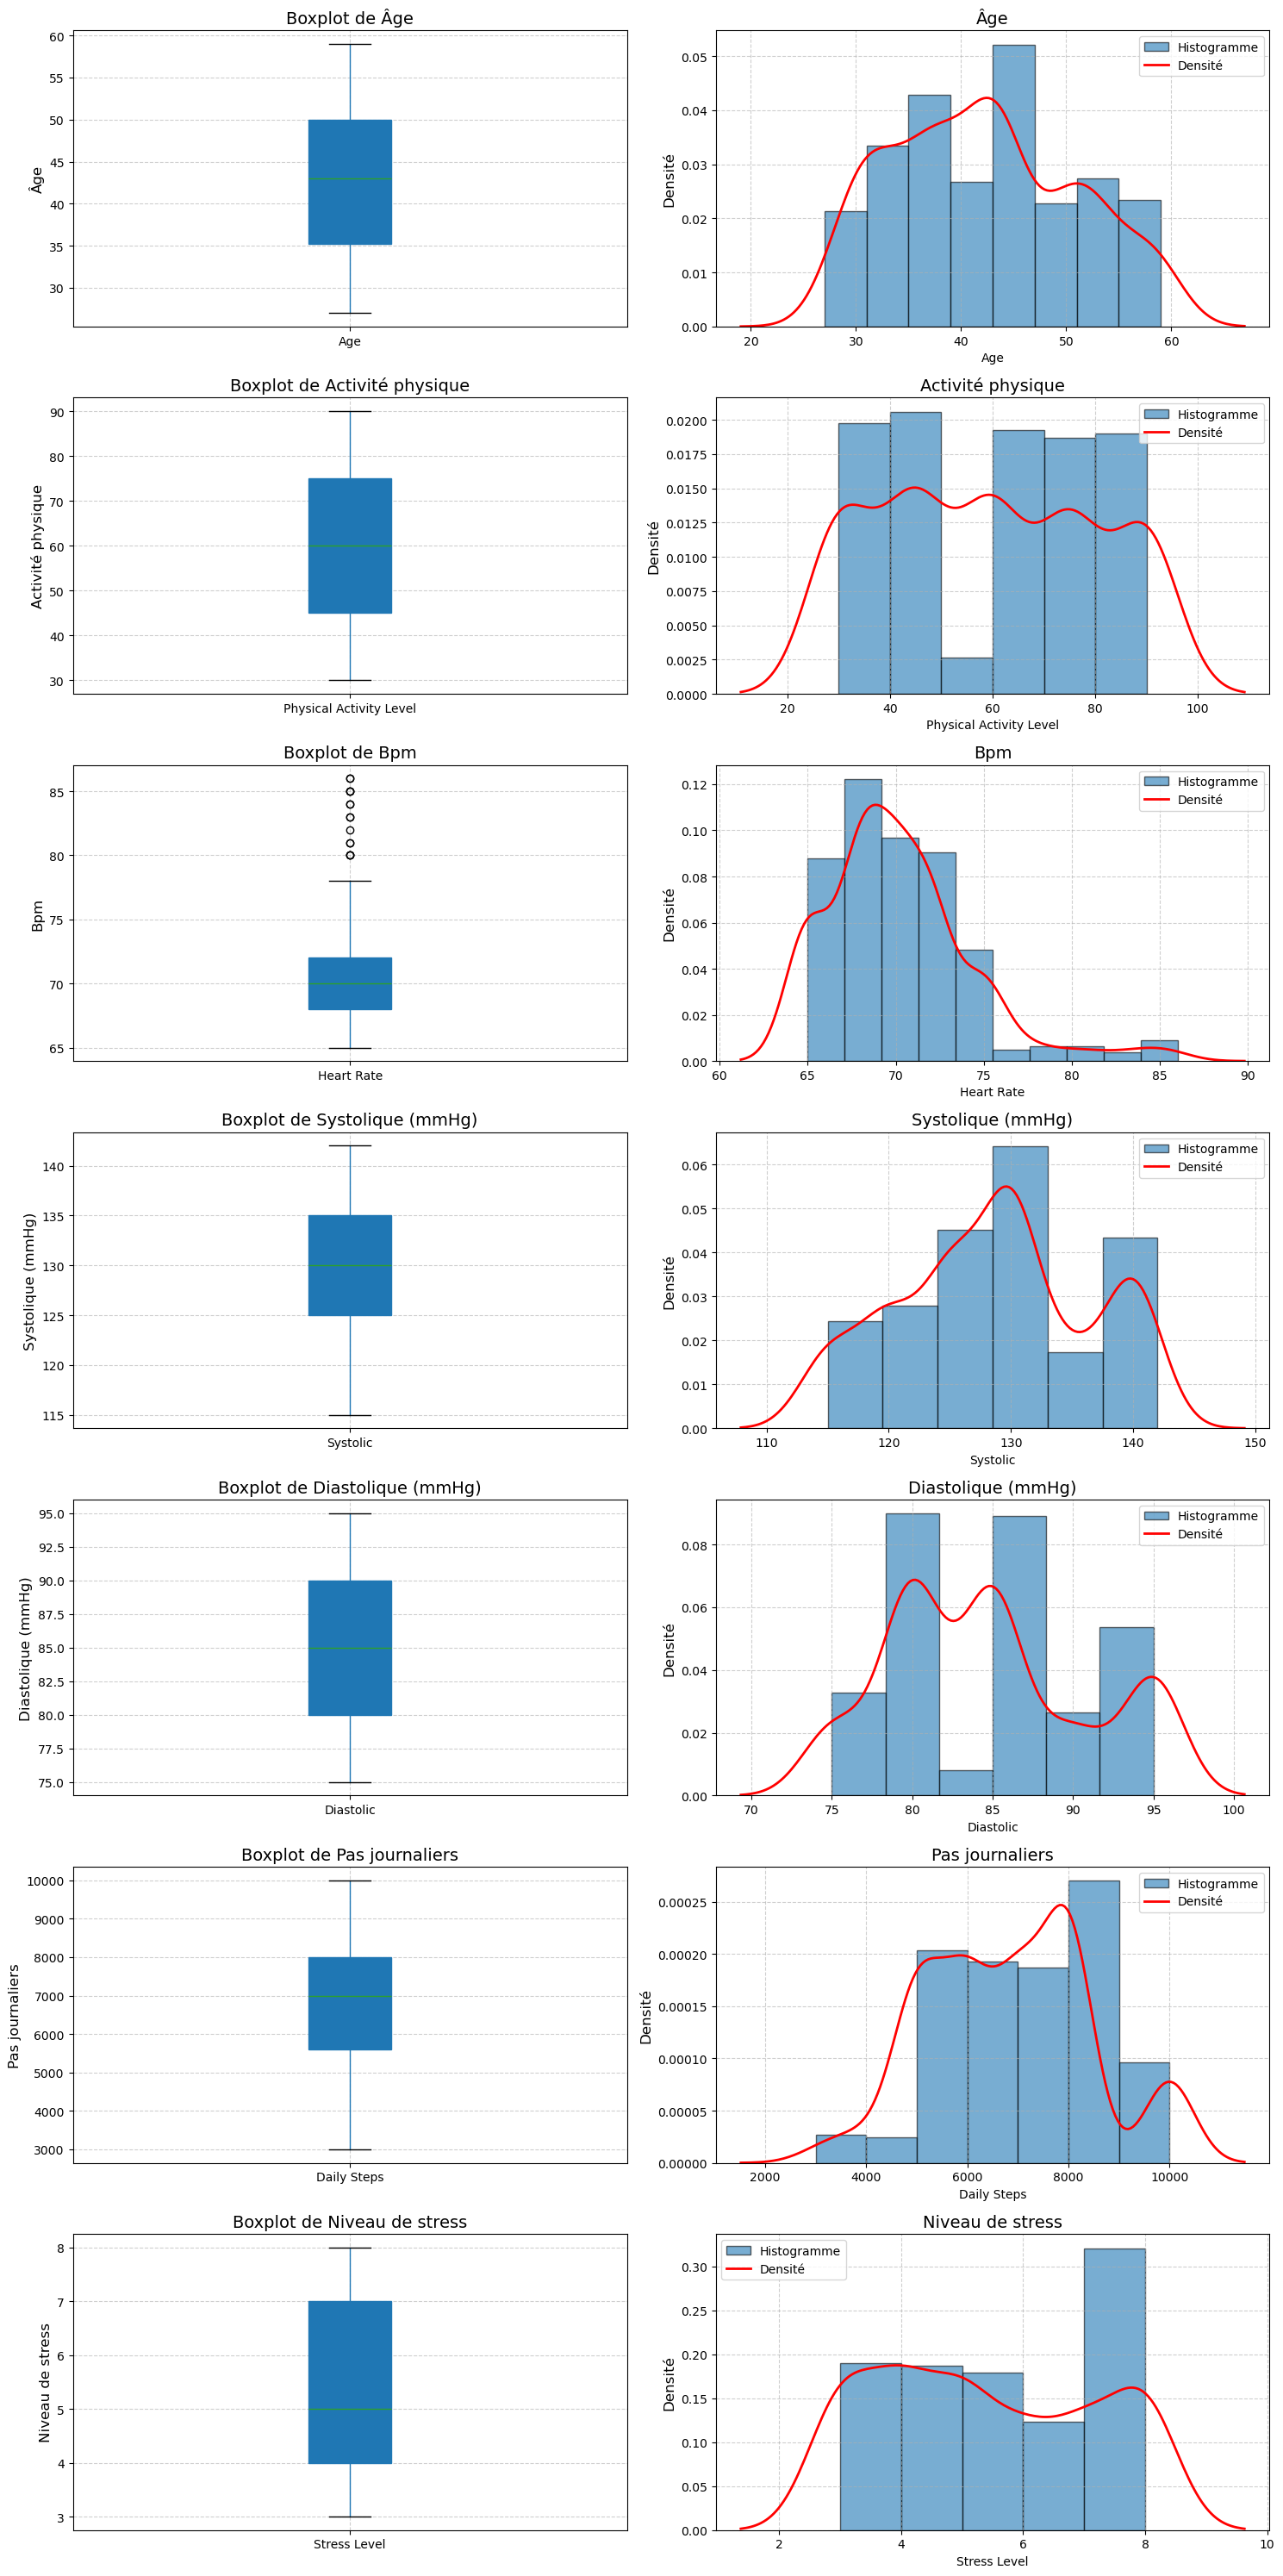

In [11]:
# Liste des variables à analyser
variables = [
    ("Age", "Âge", 8),
    ("Physical Activity Level", "Activité physique", 6),
    ("Heart Rate", "Bpm", 10),
    ("Systolic", "Systolique (mmHg)", 6),
    ("Diastolic", "Diastolique (mmHg)", 6),
    ("Daily Steps", "Pas journaliers", 7),
    ("Stress Level", "Niveau de stress", 5)
]

fig, axes = plt.subplots(len(variables), 2, figsize=(15, 30))

for i, (var, label, bin) in enumerate(variables):

    # Boxplot
    fichier.boxplot(column=var, patch_artist=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"Boxplot de {label}", fontsize=14)
    axes[i, 0].set_ylabel(label, fontsize=12)
    axes[i, 0].grid(True, linestyle="--", alpha=0.6)

    # Histogramme + KDE sur le même axe
    fichier[var].hist(ax=axes[i, 1], bins=bin, alpha=0.6, edgecolor="black", density=True, label="Histogramme")
    sns.kdeplot(fichier[var], color="red", ax=axes[i, 1], linewidth=2, label="Densité")

    axes[i, 1].set_title(f"{label}", fontsize=14)
    axes[i, 1].set_ylabel("Densité", fontsize=12)
    axes[i, 1].grid(True, linestyle="--", alpha=0.6)
    axes[i, 1].legend()  # Ajout de la légende

plt.tight_layout()
plt.show()


On peut remarquer qu'on a seulement des outliers pour les battements par minute. On ne les traitera pas pour l'instant car ce ne sont pas des valeurs trop extrêmes, mais on les garde en tête pour la suite.  
Nous nous attendions à ce que systolique et diastolique aient une distribution comparable mais ce n'est pas le cas. Les tests à venir nous permettront de déterminer s'il y a effectivement discordance entre ces deux variables.  

***Remarque :*** au vu des histogrammes, il est important de garder en tête que la plupart des données relevées, bien qu'étant numériques, sont fréquemment **arrondies à une valeur plus représentative**.   C'est notamment le cas de l'activité physique, des pressions systolique et diastolique, et des pas journaliers.  
Le niveau de stress est un cas à part puisqu'il consiste en une note donnée par la personne interrogée sur le stress qu'elle estime ressentir.

Enfin, notons aussi que nos variables, bien que symétriques, suivent difficilement des distributions gaussiennes. 

***Remarque :*** Dans toute la suite de ce projet, la variable à expliquer **"Temps de sommeil" sera notée "Y"** dans les graphiques et autres visualisations.

**Nous allons maintenant afficher la matrice de corrélation de nos variables :**

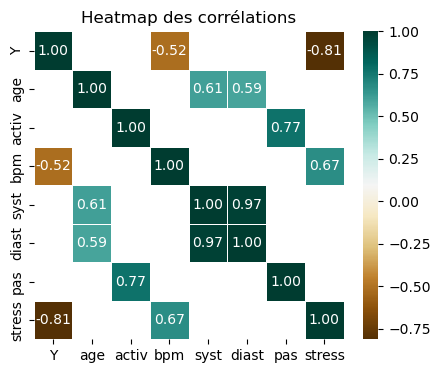

In [15]:
matcorr = pd.DataFrame(np.column_stack([np.array(Y), age, activ, battement, systolique, diastolique, pas, stress]), 
                  columns=['Y', 'age', 'activ', 'bpm', 'syst', 'diast', 'pas', 'stress'])

plt.figure(figsize=(5, 4))  # Taille du graphique
sns.heatmap(matcorr.corr()[matcorr.corr().abs() > 0.5], annot=True, cmap="BrBG", fmt=".2f", linewidths=0.5)

plt.title("Heatmap des corrélations")
plt.show()

Ici nous retrouvons des valeurs peu surprenantes, les pressions artérielles sont corrélées entre elles et avec l'âge, le nombre de pas est lié au temps d'activité quotidien et le battement cardiaque au repos est corrélé avec le niveau de stress.  
Le fait le plus marquant ici n'est pas tant la corrélation négative du temps de sommeil avec le battement cardiaque et le stress, mais plutôt son **absence de corrélation forte** avec d'autres variables telles que l'activité physique ou l'âge qui intuitivement semblent y être liées.  
Il est possible que ces facteurs aient bien une influence sur le temps de sommeil mais que ces dépendances ne soient pas linéaires, il est aussi tout à fait possible que notre intuition soit fausse et qu'aucun lien n'existe entre chacune de ces variables.

**Dans les notebooks suivants, nous allons réaliser les mêmes étapes mais cette fois-ci par variable qualitative.**
***